In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import seaborn as sea
import warnings
import datetime as dt
from sklearn.impute import SimpleImputer as skimpute
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer as Discretizer

In [2]:
dataFrame = pd.read_csv("marketing_campaign.csv", sep = ";")

In [3]:
dataFrame.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
dataFrame.shape

(2240, 29)

In [5]:
pd.set_option("display.max_columns", None)

In [6]:
warnings.filterwarnings("ignore")

In [7]:
dataFrame = dataFrame.drop(["ID"], axis = 1)

In [8]:
dataFrame.shape

(2240, 28)

In [9]:
y = dataFrame[["Response"]]
x = dataFrame.drop(["Response"], axis = 1)

In [10]:
y.shape

(2240, 1)

In [11]:
x.shape

(2240, 27)

In [12]:
y.mean()

Response    0.149107
dtype: float64

In [13]:
reference_date = dt.datetime(2024, 5, 1)
print(reference_date)

2024-05-01 00:00:00


In [14]:
#convert year of birth to age, convert dt customer to time span of user being registered customer
x["Year_Birth"] = pd.to_datetime(dataFrame["Year_Birth"], format="%Y")
x["Age"] = round((reference_date - x["Year_Birth"]).dt.days / 365, 0)
x["Dt_Customer"] = pd.to_datetime(x["Dt_Customer"])
x["Customer_Tenure"] = round((reference_date - x["Dt_Customer"]).dt.days / 365, 0)

#x = x.drop(["Year_Birth", "Dt_Customer"], axis = 1)

In [15]:
x[["Age", "Customer_Tenure"]].head()

,Age,Customer_Tenure
0,67.0,12.0
1,70.0,10.0
2,59.0,11.0
3,40.0,10.0
4,43.0,10.0


In [16]:
x = x.drop(["Year_Birth", "Dt_Customer"], axis = 1)

In [17]:
dataFrame.dtypes

Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [18]:
#split features to categorical and numerical
numerical = x.select_dtypes(include = "number")
categorical = x.select_dtypes(include = "object")

In [19]:
def uniqueness(x):
    x = x.value_counts().count()
    return x
df_value_counts = pd.DataFrame(numerical.apply(lambda x: uniqueness(x)))

In [20]:
df_value_counts.columns = ["feature_levels"]

In [21]:
df_value_counts.head()

,feature_levels
Income,1974
Kidhome,3
Teenhome,3
Recency,100
MntWines,776


In [22]:
featuresWithLessThan20levels = df_value_counts.loc[df_value_counts["feature_levels"] <= 20]
categorical_list = featuresWithLessThan20levels.index
categorical_features_from_numerical = numerical.loc[:, categorical_list]
categorical_features_from_numerical.dtypes

Kidhome                  int64
Teenhome                 int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Customer_Tenure        float64
dtype: object

In [23]:
def convert_type(x, convert_to_type):
    x = x.astype(convert_to_type)
    return x
categorical_features_from_numerical = categorical_features_from_numerical.apply(lambda x : convert_type(x, "object"))
categorical_features_from_numerical.dtypes

Kidhome                object
Teenhome               object
NumDealsPurchases      object
NumWebPurchases        object
NumCatalogPurchases    object
NumStorePurchases      object
NumWebVisitsMonth      object
AcceptedCmp3           object
AcceptedCmp4           object
AcceptedCmp5           object
AcceptedCmp1           object
AcceptedCmp2           object
Complain               object
Z_CostContact          object
Z_Revenue              object
Customer_Tenure        object
dtype: object

In [24]:
featuresWithMoreThan20levels = df_value_counts.loc[df_value_counts["feature_levels"] > 20]
numerical_list = featuresWithMoreThan20levels.index
numerical = numerical.loc[:, numerical_list]

In [25]:
categorical = pd.concat([categorical, categorical_features_from_numerical], axis = 1, join = "inner")

In [26]:
numerical.shape

(2240, 9)

In [27]:
categorical.shape

(2240, 18)

In [28]:
def cap_outliers(x):
    x = x.clip(lower = x.quantile(0.01))
    x = x.clip(upper = x.quantile(0.99))
    return x
numerical = numerical.apply(lambda x: cap_outliers(x))

In [29]:
numerical.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.85, 0.9, 0.99])

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Age
count,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,51770.277076,49.101786,302.909821,26.158482,165.075446,37.351366,26.873687,43.770089,55.132143
std,20728.704775,28.949501,333.316827,39.208270,216.547373,53.985910,40.484302,51.118104,11.666094
min,7579.200000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,32.000000
1%,7646.520000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,32.000000
5%,18985.500000,4.000000,3.000000,0.000000,4.000000,0.000000,0.000000,1.000000,36.000000
10%,24117.500000,9.000000,6.000000,0.000000,7.000000,0.000000,0.000000,3.000000,40.000000
25%,35303.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,47.000000
50%,51381.500000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,54.000000
75%,68522.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,65.000000


In [30]:
#check missing val
numerical.isnull().mean()

Income              0.010714
Recency             0.000000
MntWines            0.000000
MntFruits           0.000000
MntMeatProducts     0.000000
MntFishProducts     0.000000
MntSweetProducts    0.000000
MntGoldProds        0.000000
Age                 0.000000
dtype: float64

In [32]:
imputer = skimpute(missing_values = np.nan, strategy="mean")
numerical_imputed = pd.DataFrame(imputer.fit_transform(numerical), index = numerical.index, columns = numerical.columns)

In [33]:
numerical_imputed.isnull().mean()

Income              0.0
Recency             0.0
MntWines            0.0
MntFruits           0.0
MntMeatProducts     0.0
MntFishProducts     0.0
MntSweetProducts    0.0
MntGoldProds        0.0
Age                 0.0
dtype: float64

In [34]:
#check missing values for categorical
categorical.isnull().mean()

Education              0.0
Marital_Status         0.0
Kidhome                0.0
Teenhome               0.0
NumDealsPurchases      0.0
NumWebPurchases        0.0
NumCatalogPurchases    0.0
NumStorePurchases      0.0
NumWebVisitsMonth      0.0
AcceptedCmp3           0.0
AcceptedCmp4           0.0
AcceptedCmp5           0.0
AcceptedCmp1           0.0
AcceptedCmp2           0.0
Complain               0.0
Z_CostContact          0.0
Z_Revenue              0.0
Customer_Tenure        0.0
dtype: float64

In [38]:
#check variance
variance = VarianceThreshold(threshold=0)
variance.fit_transform(numerical_imputed)
affected_columns = variance.get_support(indices = True)
numerical_imputed_variance_checked = numerical_imputed.iloc[:, affected_columns]

In [39]:
numerical_imputed_variance_checked.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Age
0,58138.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,67.0
1,46344.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,70.0
2,71613.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,59.0
3,26646.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,40.0
4,58293.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,43.0


In [42]:
#feature discretization
discretizer = Discretizer(n_bins=10, encode = "ordinal", strategy = "quantile")
numerical_binned = pd.DataFrame(discretizer.fit_transform(numerical_imputed_variance_checked), index = numerical_imputed_variance_checked.index, columns = numerical_imputed_variance_checked.columns).add_suffix("_Discrete")
numerical_binned.head()

,Income_Discrete,Recency_Discrete,MntWines_Discrete,MntFruits_Discrete,MntMeatProducts_Discrete,MntFishProducts_Discrete,MntSweetProducts_Discrete,MntGoldProds_Discrete,Age_Discrete
0,5.0,5.0,8.0,8.0,9.0,8.0,7.0,8.0,8.0
1,4.0,3.0,1.0,1.0,0.0,1.0,1.0,2.0,8.0
2,7.0,2.0,7.0,7.0,6.0,7.0,5.0,6.0,6.0
3,1.0,2.0,1.0,3.0,3.0,3.0,2.0,1.0,1.0
4,6.0,9.0,4.0,6.0,6.0,6.0,6.0,3.0,1.0


In [43]:
x_binned_combined = pd.concat([y, numerical_binned], axis = 1, join = "inner")

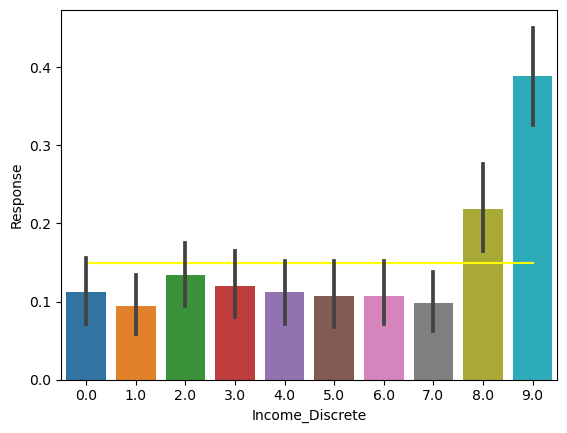

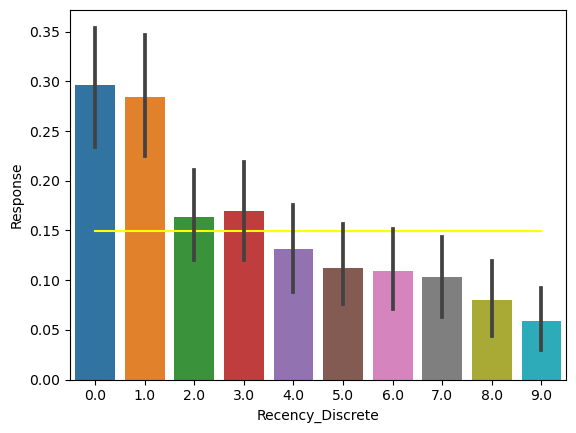

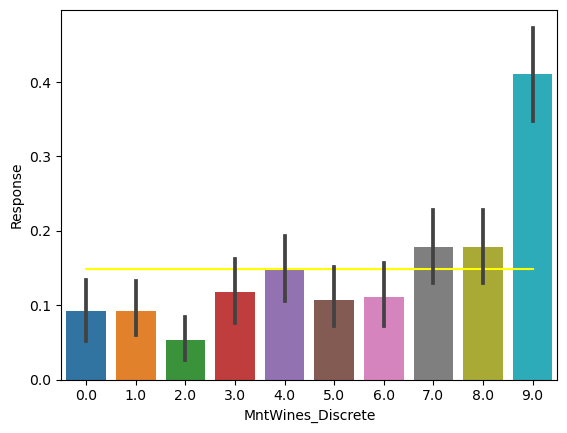

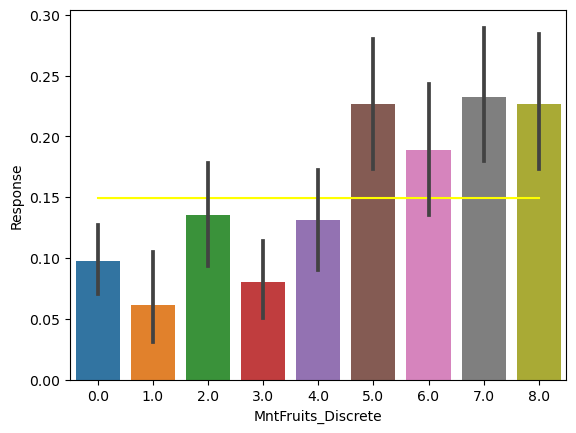

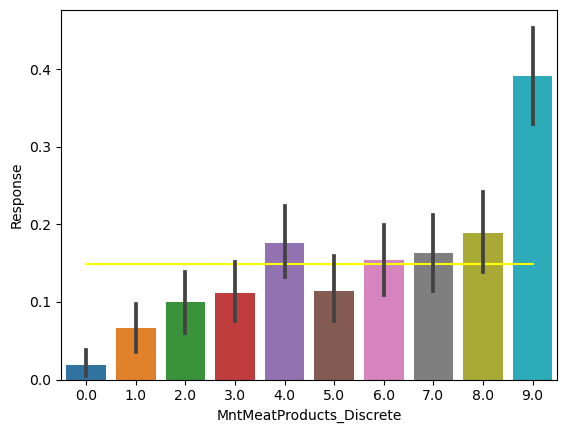

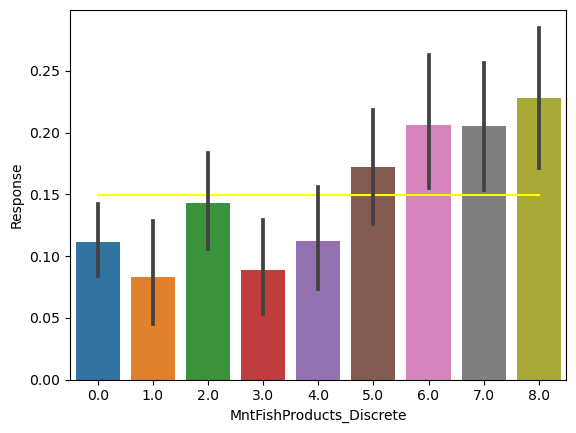

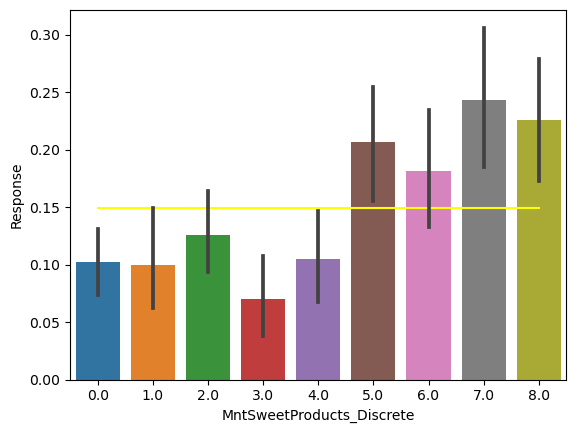

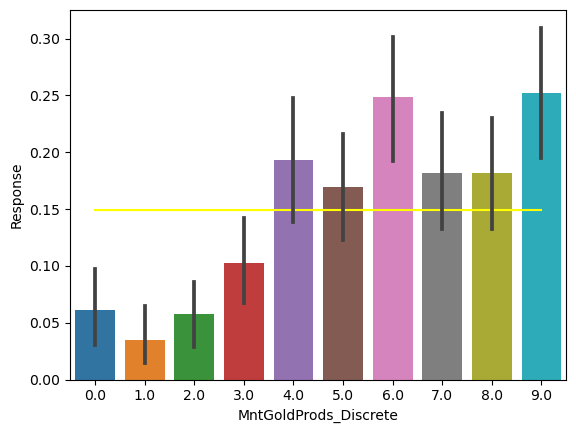

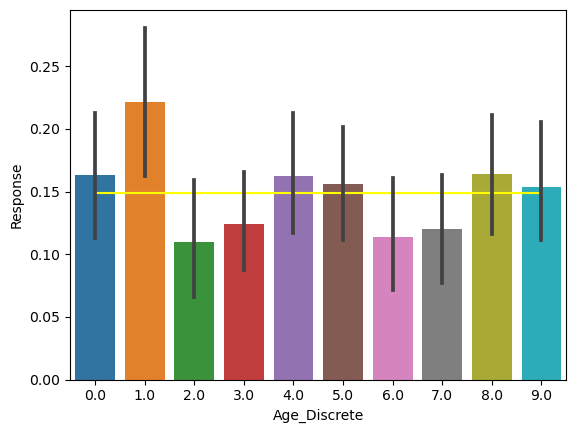

In [46]:
#check correlation for every col regarding to target var
from numpy import mean
for column in numerical_binned.columns:
    mpl.figure()
    sea.lineplot(x = column, y = x_binned_combined["Response"].mean(), data = x_binned_combined, color="yellow")
    sea.barplot(x = column, y = "Response", data = x_binned_combined, estimator = mean)
mpl.show()

In [49]:
numerical_imputed_variance_checked = numerical_imputed_variance_checked.drop(["Age"], axis = 1)
numerical_imputed_variance_checked.shape

(2240, 8)

In [50]:
numerical_imputed_variance_checked.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,58138.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0
1,46344.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0
2,71613.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0
3,26646.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0
4,58293.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0


In [52]:
#select 6 best features
selector = SelectKBest(chi2, k = 6)
selector.fit_transform(numerical_imputed_variance_checked, y)
columns = selector.get_support(indices = True)
selected_numerical_features = numerical_imputed.iloc[:, columns]
selected_numerical_features.iloc[0]

Income             58138.0
MntWines             635.0
MntFruits             88.0
MntMeatProducts      546.0
MntFishProducts      172.0
MntGoldProds          88.0
Name: 0, dtype: float64

In [ ]:
#categorical features selection